In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 128
image_size = 64
noise_dim = 100
num_epochs = 10
learning_rate = 0.0002
beta1 = 0.5

In [4]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.CIFAR10(root="./data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.net(noise)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

In [7]:
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

In [8]:
adversarial_loss = nn.BCELoss()

In [9]:
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [10]:
fixed_noise = torch.randn(64, noise_dim, 1, 1, device=device)

In [11]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, device="cpu"):
    model.eval()
    activations = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(device)
            pred = model(batch).view(batch.size(0), -1)
            activations.append(pred.cpu().numpy())

    activations = np.concatenate(activations, axis=0)
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    if not np.isfinite(covmean).all():
        covmean = sqrtm((sigma1 + eps).dot(sigma2 + eps))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

In [12]:
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = nn.Identity()
inception_model.to(device)

/home/kviduda/.conda/envs/pytorch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kviduda/.conda/envs/pytorch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [13]:
gen_losses = []
disc_losses = []
fid_scores = []

for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_imgs = generator(noise).detach()
        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs)

        d_loss_real = adversarial_loss(real_validity, valid)
        d_loss_fake = adversarial_loss(fake_validity, fake)
        d_loss = d_loss_real + d_loss_fake

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        fake_validity = discriminator(fake_imgs)

        g_loss = adversarial_loss(fake_validity, valid)
        g_loss.backward()
        optimizer_g.step()

        gen_losses.append(g_loss.item())
        disc_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)} "
                  f"Loss D: {d_loss:.4f}, Loss G: {g_loss:.4f}")

    # FID Calculation
    resized_real = nn.functional.interpolate(real_imgs, size=(299, 299), mode='bilinear')
    resized_fake = nn.functional.interpolate(fake_imgs, size=(299, 299), mode='bilinear')
    mu_real, sigma_real = calculate_activation_statistics(resized_real, inception_model, device=device)
    mu_fake, sigma_fake = calculate_activation_statistics(resized_fake, inception_model, device=device)
    fid = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    fid_scores.append(fid)
    print(f"Epoch [{epoch+1}/{num_epochs}] FID Score: {fid:.4f}")

    # Save generated images
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    img_grid_fake = utils.make_grid(fake, normalize=True, padding=2)
    img_grid_real = utils.make_grid(real_imgs[:64], normalize=True, padding=2)

Epoch [1/10] Batch 0/391 Loss D: 1.4551, Loss G: 2.9847
Epoch [1/10] Batch 100/391 Loss D: 0.5815, Loss G: 2.5067
Epoch [1/10] Batch 200/391 Loss D: 0.8725, Loss G: 2.7746
Epoch [1/10] Batch 300/391 Loss D: 0.2913, Loss G: 2.6194
Epoch [1/10] FID Score: 417.4956
Epoch [2/10] Batch 0/391 Loss D: 0.4972, Loss G: 2.9859
Epoch [2/10] Batch 100/391 Loss D: 0.3871, Loss G: 2.7980
Epoch [2/10] Batch 200/391 Loss D: 0.8448, Loss G: 7.3274
Epoch [2/10] Batch 300/391 Loss D: 0.6631, Loss G: 2.1946
Epoch [2/10] FID Score: 353.4164
Epoch [3/10] Batch 0/391 Loss D: 0.2103, Loss G: 3.4957
Epoch [3/10] Batch 100/391 Loss D: 2.6107, Loss G: 0.9573
Epoch [3/10] Batch 200/391 Loss D: 0.5402, Loss G: 1.7967
Epoch [3/10] Batch 300/391 Loss D: 0.3041, Loss G: 2.4354
Epoch [3/10] FID Score: 351.8808
Epoch [4/10] Batch 0/391 Loss D: 0.1490, Loss G: 4.5064
Epoch [4/10] Batch 100/391 Loss D: 0.3844, Loss G: 3.3603
Epoch [4/10] Batch 200/391 Loss D: 0.4647, Loss G: 2.0408
Epoch [4/10] Batch 300/391 Loss D: 0.27

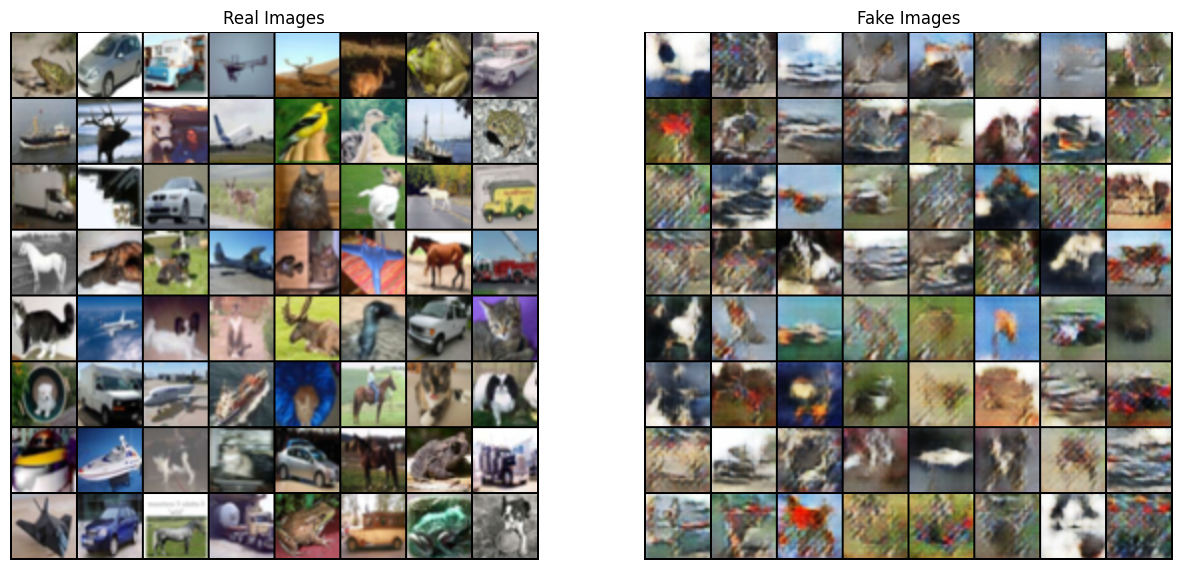

In [14]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(img_grid_real, (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_grid_fake, (1, 2, 0)))
plt.show()

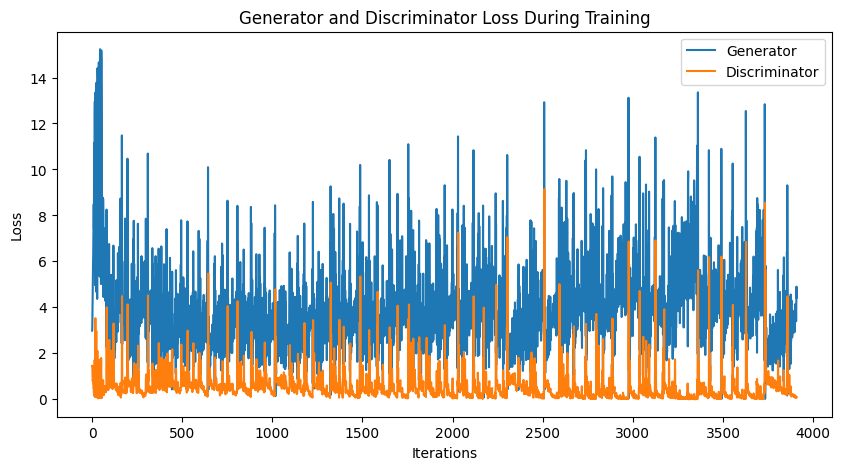

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

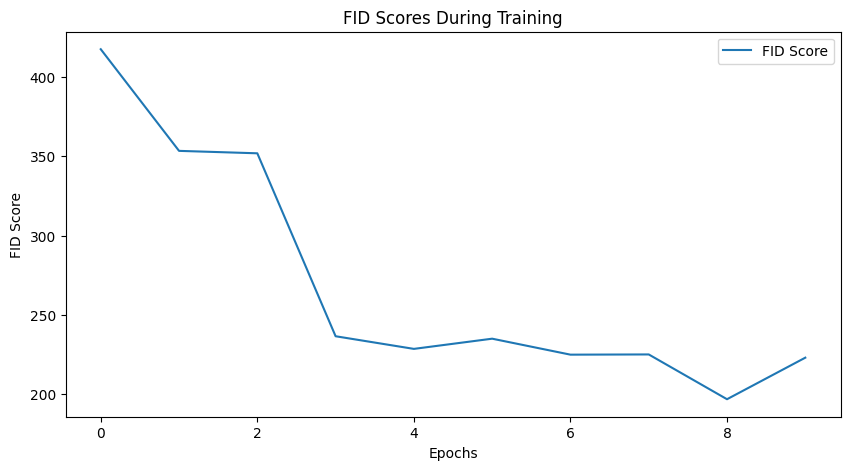

In [16]:
plt.figure(figsize=(10, 5))
plt.title("FID Scores During Training")
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.legend()
plt.show()